In [1]:
# import libraries
from collections import defaultdict
import pandas as pd
import numpy as np

# defines the mapreduce function
def mapreduce(mapper, reducer, data):
    # map phase
    mdata = [pair for item in data for pair in mapper(item)]

    # shuffles and sorts
    sdata = defaultdict(list)
    for key, value in mdata:
        sdata[key].append(value)
    sitems = sdata.items()

    # reduces the data
    rdata = [reducer(item) for item in sitems]
    rdata = [x for x in rdata if x is not None]  # drop None pairs

    return rdata, [len(item) for item in data], len(mdata), len(sdata)


In [2]:
# defines the mapper function for word counting
def wcmapper(data):
    key_value_pairs = []
    for line in data:
        words = line.split()
        for word in words:
            key_value_pairs.append((word.lower(), 1))  # convert to lowercase
    return key_value_pairs

# defines the reducer function for word counting
def wcreducer(key_value):
    key, values = key_value
    return (key, sum(values))  


In [19]:
# sample input data
input_texts = [
    "data science is fun",
    "machine learning and artificial intelligence",
    "big data is powerful",
    "hello data science world",
    "artificial intelligence is the future",
    "data science and big data"
]


# mapreduce with input as a single chunk
result_singlechunk, _, _, _ = mapreduce(
    lambda data: wcmapper(data),
    lambda item: wcreducer(item),
    [input_texts]
)

# mapreduce with input split into multiple chunks
result_multchunks, _, _, _ = mapreduce(
    lambda data: wcmapper(data),
    lambda item: wcreducer(item),
    [[line] for line in input_texts]  # splits single-line chunks
)

# displays results
print("Single Chunk:", result_singlechunk)
print("Multiple Chunks:", result_multchunks)


Single Chunk: [('data', 5), ('science', 3), ('is', 3), ('fun', 1), ('machine', 1), ('learning', 1), ('and', 2), ('artificial', 2), ('intelligence', 2), ('big', 2), ('powerful', 1), ('hello', 1), ('world', 1), ('the', 1), ('future', 1)]
Multiple Chunks: [('data', 5), ('science', 3), ('is', 3), ('fun', 1), ('machine', 1), ('learning', 1), ('and', 2), ('artificial', 2), ('intelligence', 2), ('big', 2), ('powerful', 1), ('hello', 1), ('world', 1), ('the', 1), ('future', 1)]


In [4]:
# loads in data
basket_data = pd.read_csv("basket.csv", header=None)

# flattens the dataset into array and count occurrences of each item
all_items = basket_data.values.flatten()  
all_items = pd.Series(all_items).dropna()  # Drop nan values
all_items = all_items[all_items.str.isalpha()]

# frequency of the items
item_counts = all_items.value_counts()

# 10 most and least common items
mostcitems = item_counts.head(10)
leastcitems = item_counts.tail(10)

# results
print("Most Common:")
print(mostcitems)

print("\nLeast Common:")
print(leastcitems)


Most Common:
soda           1514
yogurt         1334
sausage         924
pastry          785
newspapers      596
frankfurter     580
pork            566
butter          534
beef            516
curd            514
Name: count, dtype: int64

Least Common:
syrup          21
soap           20
prosecco       19
cookware       17
honey          13
cream          12
liqueur         9
decalcifier     9
whisky          8
bags            4
Name: count, dtype: int64


In [5]:
from mlxtend.preprocessing import TransactionEncoder

# converts each row to a list of items
basketlist = basket_data.apply(lambda row: row.dropna().tolist(), axis=1).tolist()

# one-hot encode the data
te = TransactionEncoder()
basketoneh = te.fit_transform(basketlist)
basketoneh_df = pd.DataFrame(basketoneh, columns=te.columns_)



In [6]:
from mlxtend.frequent_patterns import fpgrowth

# different thresholds
thresholds = [0.01, 0.005, 0.001]  # range of thresholds

for support in thresholds:
    frequent_itemsets = fpgrowth(basketoneh_df, min_support=support, use_colnames=True)
    print(f"\nSupport Thresh: {support}")
    print(f"Num of Freq Itemsets: {len(frequent_itemsets)}")
    print(frequent_itemsets.head())



Support Thresh: 0.01
Num of Freq Itemsets: 69
    support       itemsets
0  0.157912   (whole milk)
1  0.051724       (pastry)
2  0.018778  (salty snack)
3  0.085873       (yogurt)
4  0.060345      (sausage)

Support Thresh: 0.005
Num of Freq Itemsets: 126
    support       itemsets
0  0.157912   (whole milk)
1  0.051724       (pastry)
2  0.018778  (salty snack)
3  0.085873       (yogurt)
4  0.060345      (sausage)

Support Thresh: 0.001
Num of Freq Itemsets: 750
    support       itemsets
0  0.157912   (whole milk)
1  0.051724       (pastry)
2  0.018778  (salty snack)
3  0.085873       (yogurt)
4  0.060345      (sausage)


In [8]:
from mlxtend.frequent_patterns import fpgrowth, association_rules

# generate frequent itemsets with minimum support of 0.0005
frequentis = fpgrowth(basketoneh_df, min_support=0.0005, use_colnames=True)

# generate association rules with lift >= 2
numis = len(frequent_itemsets)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=2, num_itemsets=numis)

# Display the resulting rules
print("Association Rules with a Lift of at least 2:")
print(rules)


Association Rules with a Lift of at least 2:
            antecedents           consequents  antecedent support  \
0  (whole milk, yogurt)             (sausage)            0.011160   
1             (sausage)  (whole milk, yogurt)            0.060345   

   consequent support  support  confidence      lift  representativity  \
0            0.060345  0.00147    0.131737  2.183062               1.0   
1            0.011160  0.00147    0.024363  2.183062               1.0   

   leverage  conviction  zhangs_metric   jaccard  certainty  kulczynski  
0  0.000797    1.082224       0.548044  0.020992   0.075976     0.07805  
1  0.000797    1.013533       0.576731  0.020992   0.013352     0.07805  


In [9]:
from mlxtend.frequent_patterns import fpgrowth

# mapper function for frequent itemsets
def frequentismapper(data_chunk):
    # computes frequent itemsets on the chunk
    frequentis = fpgrowth(data_chunk, min_support=0.0005, use_colnames=True)
    
    # generates key,value pairs
    kvpairs = []
    for _, row in frequentis.iterrows():
        itemset = frozenset(row['itemsets'])  # key: itemset as a frozenset
        cnt = row['support'] * len(data_chunk)  # value: count derived from support
        kvpairs.append((itemset, cnt))
    return kvpairs


In [10]:
# reducer function
def frequentisreducer(key_value):
    key, values = key_value  # key: itemset, values: list of counts
    ts = sum(values)
    if ts >= 0.0005:  # checks threshold
        return (key, ts)  #returns itemset and total support
    return None  # or excludes ones below the threshold


In [16]:
import numpy as np

# defines splits 
splits = [2, 4, 8, 16]
moutputs = []
skeys = []

# takes a bit to run
for nchunks in splits:
    # splits into chunks
    chunkeddata = np.array_split(basketoneh_df, nchunks)
    
    # runs mapreduce on the chunks
    _, mapper_lengths, lenm, lens = mapreduce(
        lambda data: frequentismapper(data),
        lambda item: frequentisreducer(item),
        chunkeddata
    )
    
    # results
    moutputs.append(lenm)
    skeys.append(lens)


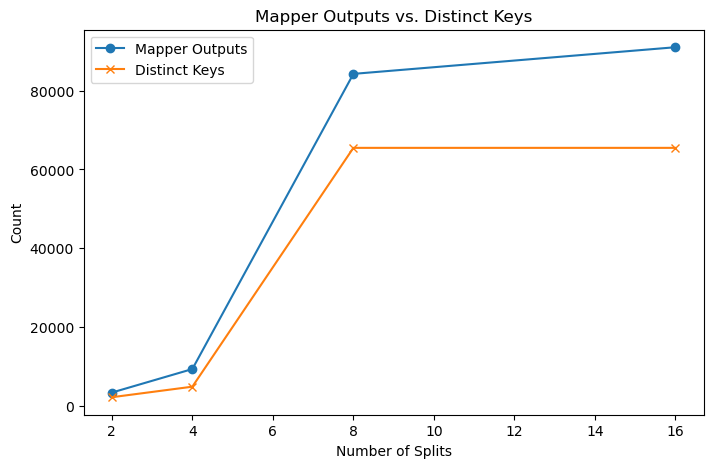

In [17]:
import matplotlib.pyplot as plt

# plot
plt.figure(figsize=(8, 5))
plt.plot(splits, moutputs, label='Mapper Outputs', marker='o')
plt.plot(splits, skeys, label='Distinct Keys', marker='x')
plt.xlabel('Number of Splits')
plt.ylabel('Count')
plt.title('Mapper Outputs vs. Distinct Keys')
plt.legend()
plt.show()


In [18]:
"""
The graph generated from this code shows the impact of varying the number of splits on two metrics: 
mapper outputs and distinct keys. 

Mapper outputs increase as the number of splits grows because each split processes independently, 
resulting in redundant computations and duplicate key-value pairs for overlapping frequent itemsets. 
This redundancy increases the total number of intermediate outputs.

Distinct keys, however, plateau after the shuffle and reduce phases, as duplicates are consolidated 
to reflect the actual number of unique frequent itemsets in the data. 

The results confirm that while splitting allows for smaller chunks to be processed, it introduces 
overhead due to redundant mapper outputs, emphasizing the need for a balance between the number of 
splits and computational efficiency.
"""


'\nThe graph generated from this code shows the impact of varying the number of splits on two metrics: \nmapper outputs and distinct keys. \n\nMapper outputs increase as the number of splits grows because each split processes independently, \nresulting in redundant computations and duplicate key-value pairs for overlapping frequent itemsets. \nThis redundancy increases the total number of intermediate outputs.\n\nDistinct keys, however, plateau after the shuffle and reduce phases, as duplicates are consolidated \nto reflect the actual number of unique frequent itemsets in the data. \n\nThe results confirm that while splitting allows for smaller chunks to be processed, it introduces \noverhead due to redundant mapper outputs, emphasizing the need for a balance between the number of \nsplits and computational efficiency.\n'